In [1]:
import open3d as o3d
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import imageio
from tqdm import tqdm

# only needed for tutorial, monkey patches visualization
sys.path.append('/home/ruslan/subt/thirdparty/Open3D/examples/python/')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/RGBD/normal_map.npy already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/RGBD/raycast_vtx_004.npy already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/tests/bunnyData.pts already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/tests/point_cloud_sample1.pts already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/tests/point_cloud_sample2.pts already exists, skipped.
[download_utils.py] /home/ruslan/subt/thirdparty/Open3D/examples/test_data/open3d_downloads/tests/cube.obj already exists

In [2]:
path = "../ros_ws/src/gradslam_ros/data/explorer_x1_rgbd_traj/living_room_traj1_frei_png/"
# path = "../examples/tutorials/ICL/living_room_traj1_frei_png/"

In [3]:
ind = 12
# ind = np.random.randint(0, 553)
color_img = imageio.imread(path+f"rgb/{ind}.png")
# depth_img = imageio.imread(path+f"depth/{ind}.png")
depth_img = np.load(path+f"depth/{ind}.npy")

In [4]:
depth_img.shape, color_img.shape

((240, 320), (240, 320, 3))

In [5]:
color_raw = o3d.io.read_image(path+f"rgb/{ind}.png")
depth_raw = o3d.io.read_image(path+f"depth/{ind}.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw)

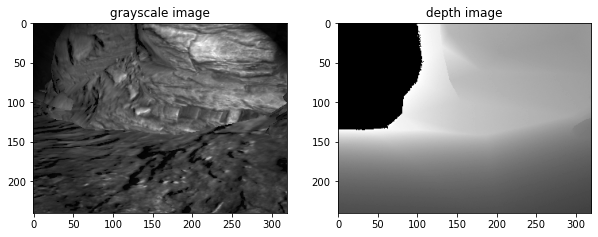

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('grayscale image')
plt.imshow(rgbd_image.color, cmap="gray")
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(rgbd_image.depth, cmap="gray")
plt.show()

In [7]:
K = np.load(path+f"caminfo/{ind}.npy")
intrinsics = o3d.camera.PinholeCameraIntrinsic(width=color_img.shape[0], height=color_img.shape[1],
                                               fx=K[0, 0], fy=K[1, 1], cx=K[0, 2], cy=K[1, 2])

In [8]:
K

array([[277.1,   0. , 160.5],
       [  0. , 277.1, 120.5],
       [  0. ,   0. ,   1. ]], dtype=float32)

### Create point cloud from RGBD image

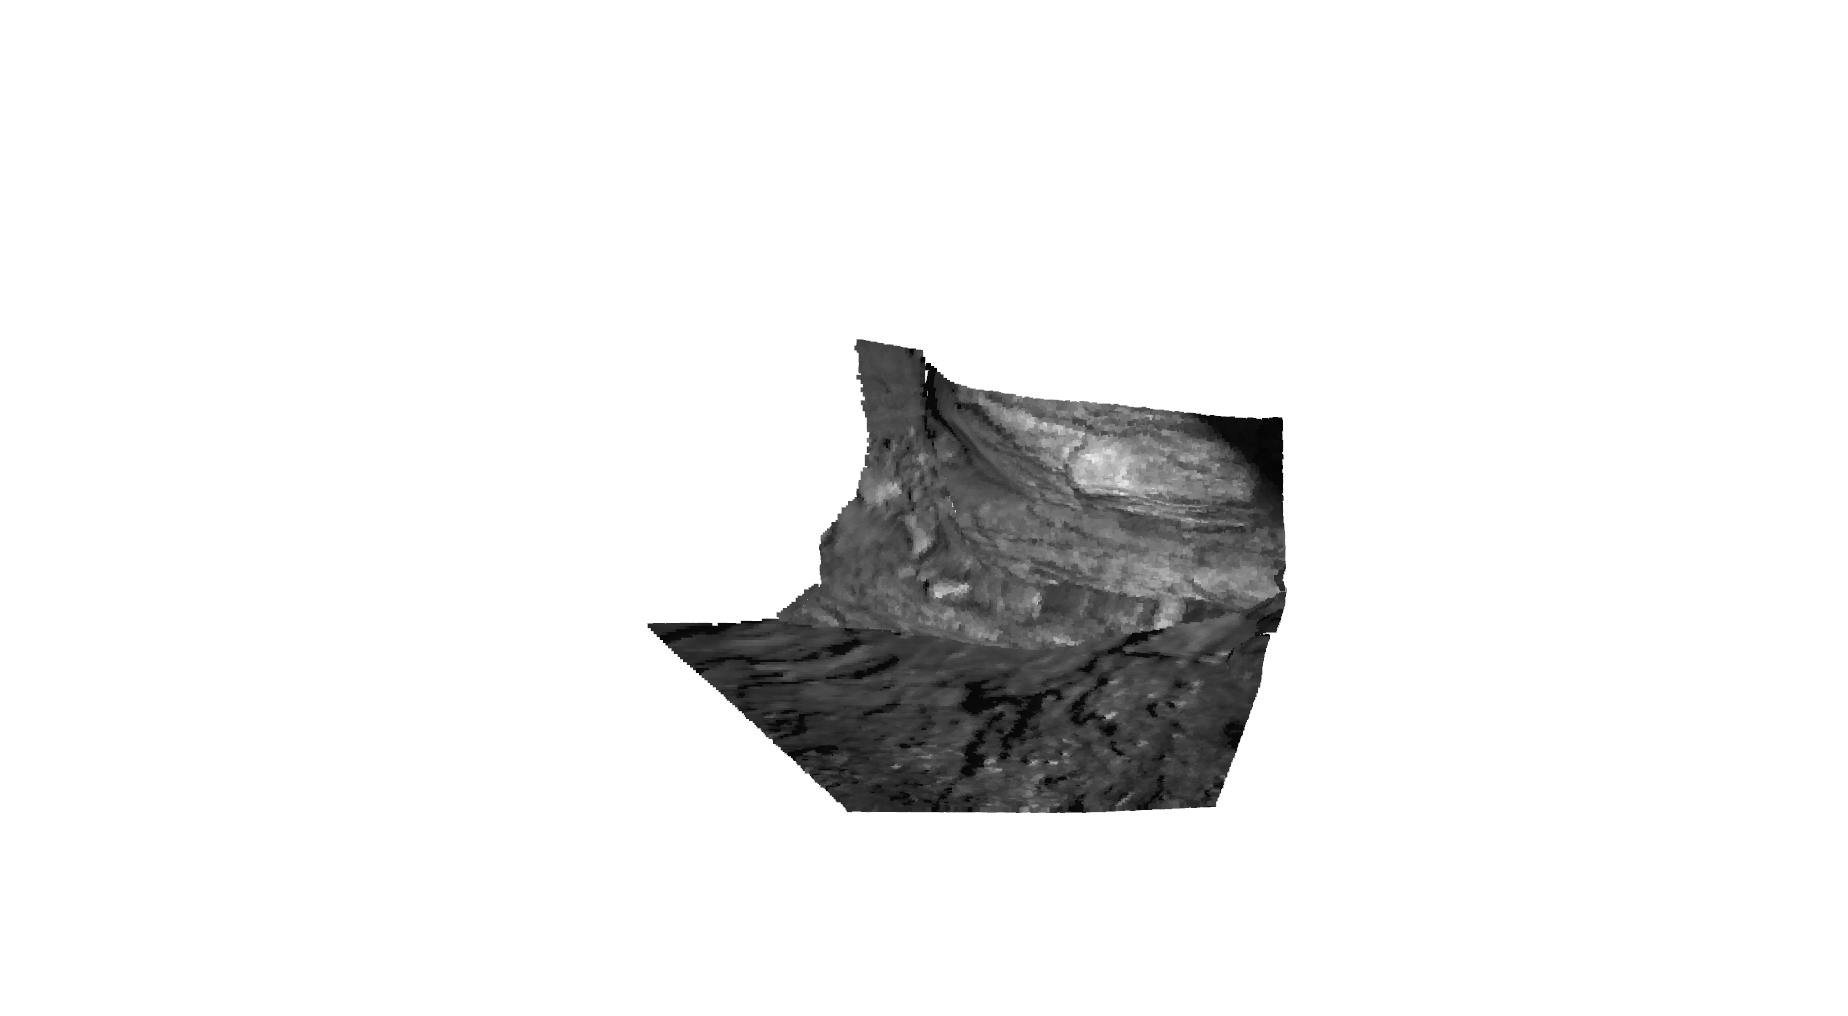

PointCloud with 64238 points.


In [9]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsics)
# pcd = o3d.geometry.PointCloud.create_from_depth_image(depth_raw, intrinsics)
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

o3d.visualization.draw_geometries([pcd])
print(pcd)

### Estimate Normals from Points

Downsample the point cloud with a voxel of 0.1


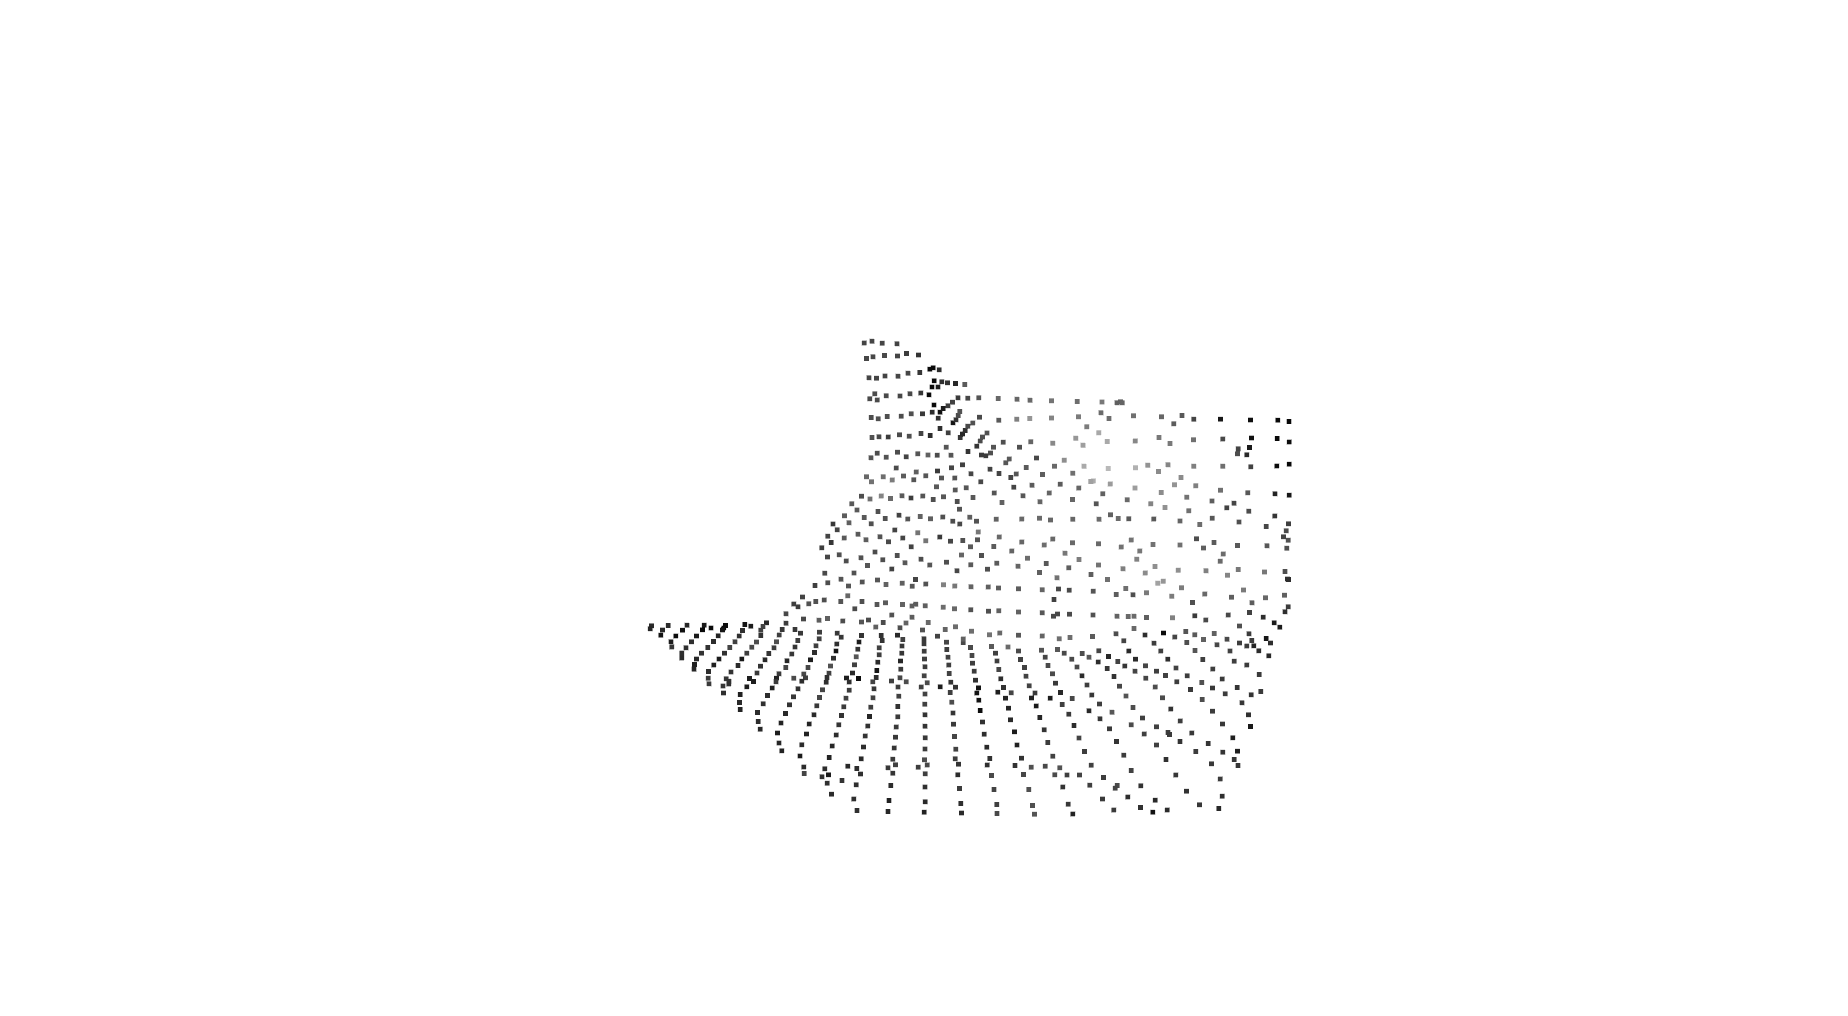

PointCloud with 64238 points.


In [10]:
print("Downsample the point cloud with a voxel of 0.1")
downpcd = pcd.voxel_down_sample(voxel_size=0.1)
o3d.visualization.draw_geometries([downpcd])
print(pcd)

Open3D can be used to estimate point cloud normals with `estimate_normals`, which locally fits a plane per 3D point to derive the normal.

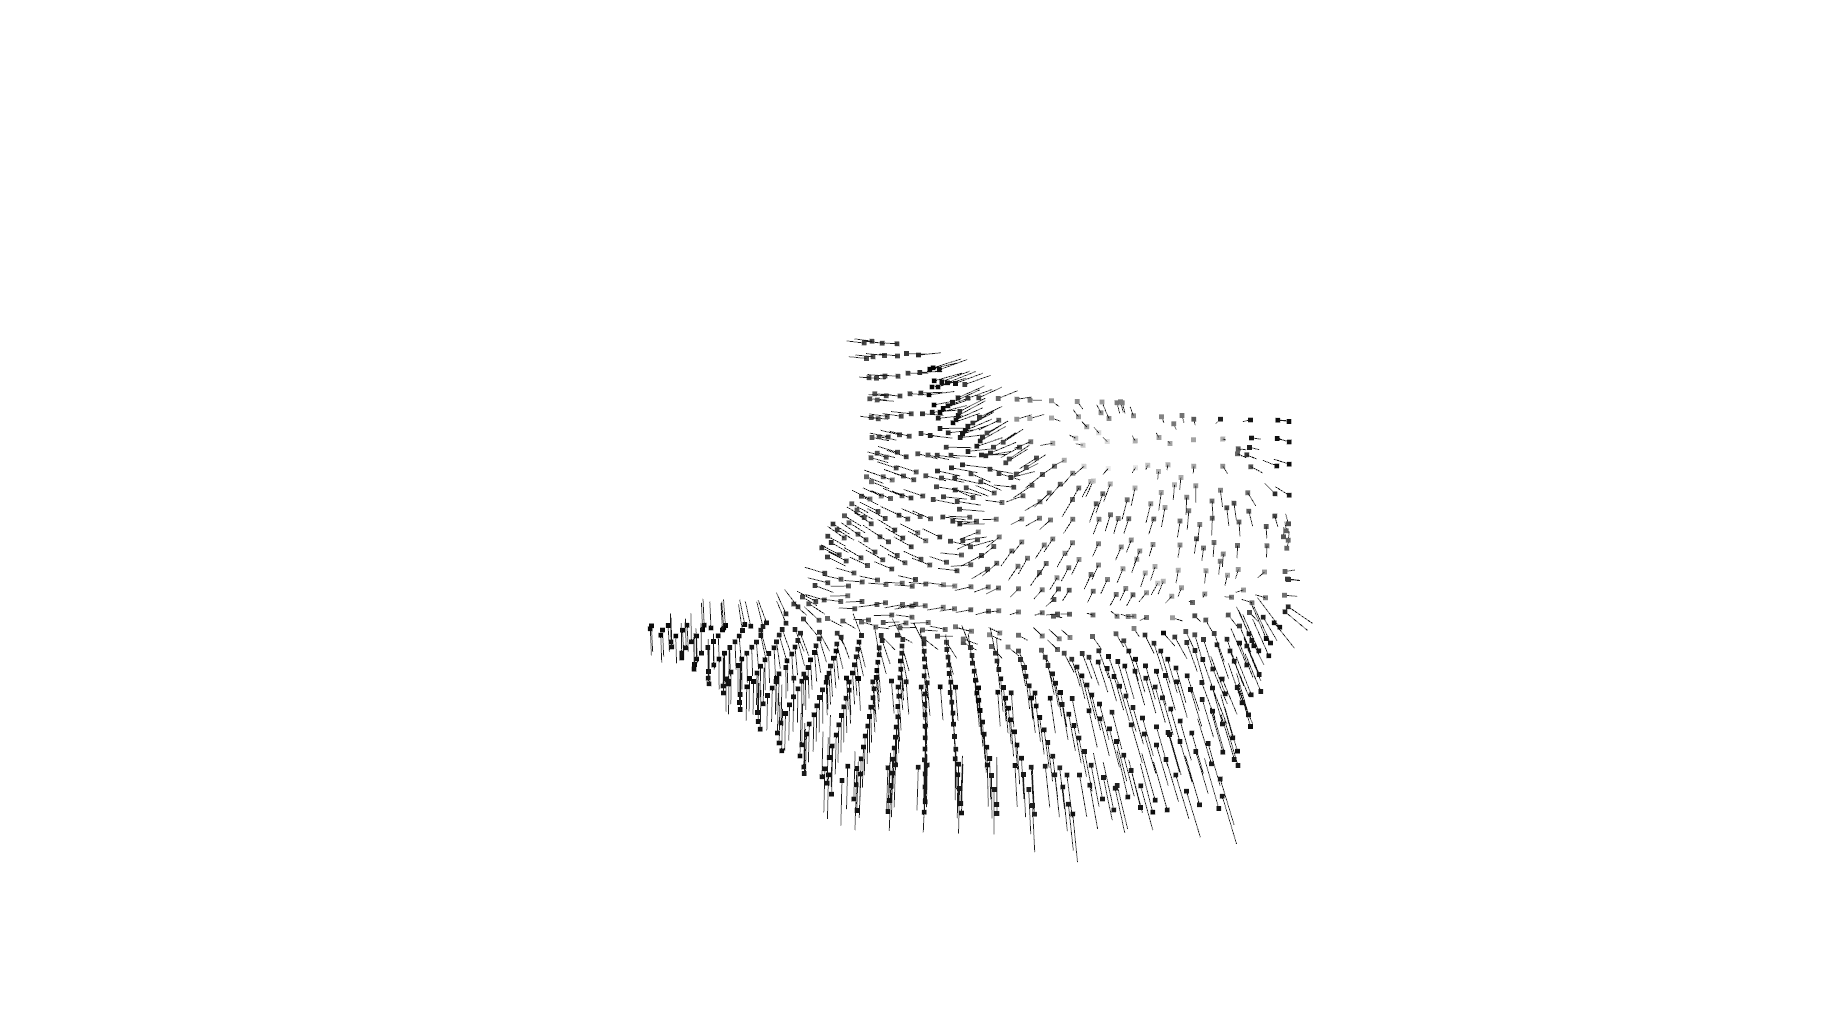

In [11]:
downpcd.estimate_normals()
o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

However, the estimated normals might not be consistently oriented. `orient_normals_consistent_tangent_plane` propagates the normal orientation using a minimum spanning tree.

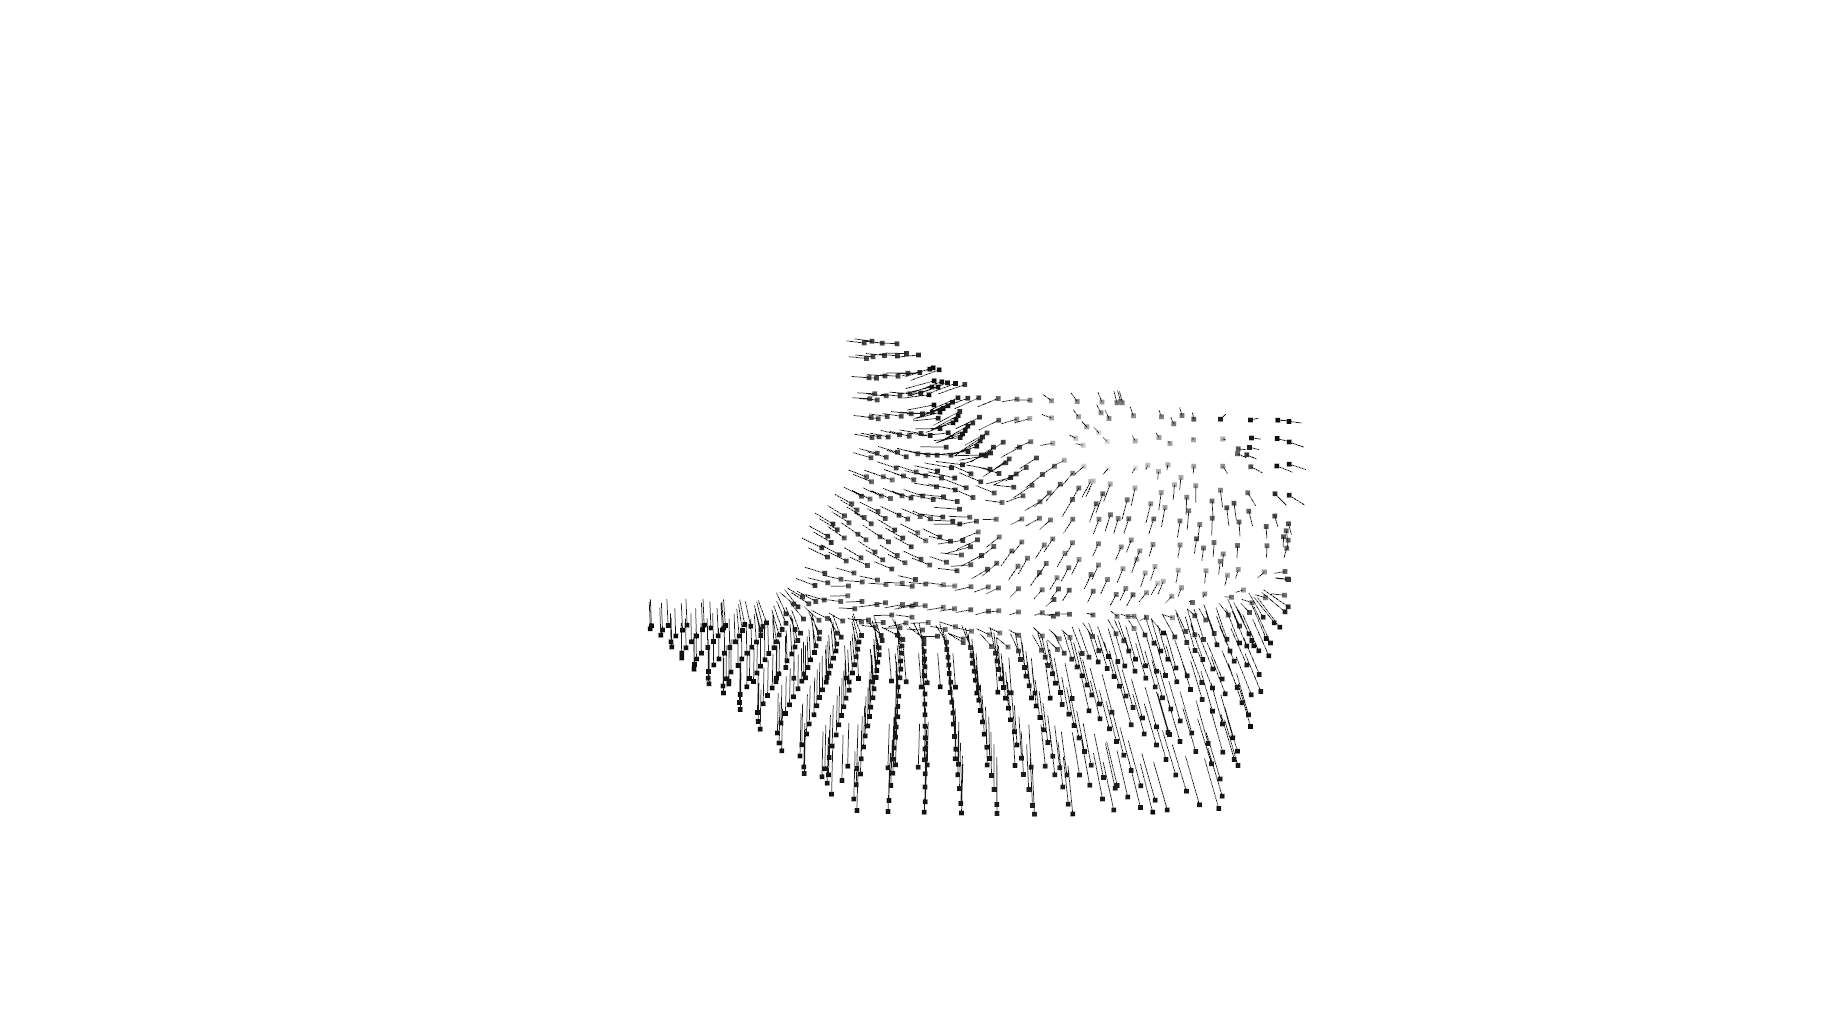

In [12]:
# https://stackoverflow.com/questions/60346126/consistent-normal-calculation-of-a-point-cloud
downpcd.orient_normals_consistent_tangent_plane(k=15)
o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

### Calculate angles from normals

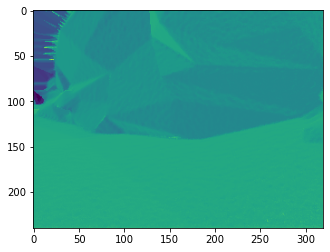

In [58]:
pcd = o3d.geometry.PointCloud.create_from_depth_image(depth_raw, intrinsics)
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(k=15)
pcd.normalize_normals()

# v_u = np.array([0., 0., 1.])
# n_u = np.asarray(pcd.normals)
# angles = np.arccos(np.clip(n_u @ v_u, -1.0, 1.0))

# angle between a ray going from camera to a point and a normal in that point
n_u = np.asarray(pcd.normals)
v_u = np.asarray(pcd.points) / np.linalg.norm(np.asarray(pcd.points))
coss = []
for n, v in zip(n_u, v_u):
    cos = n @ v
    coss.append(cos)
angles = np.arccos(np.clip(coss, -1., 1.))

angles_show = np.asarray(angles.reshape([*depth_img.shape]))
plt.imshow(angles_show);